# Сессия 3

### Описание задачи

В этой сессии вы продолжаете работать с данными, подготовленными в предыдущей сессии.
Вам предстоит выполнить регрессионный анализ данных. Модель должна строить предсказания на
среднесрочный период. Какая-либо работа, обусловленная задачами предыдущей сессии,
выполненная в ходе текущей, оцениваться не будет, поэтому проделывайте её только в случае
необходимости.

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from pmdarima import auto_arima
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [3]:
# считывание набора данных
data = pd.read_csv("output.csv")

In [4]:
data.head(10)

,total_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,RT,LocationID,year,month,day,cluster
0,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,5.0,0
1,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,6.0,0
2,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,7.0,0
3,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,8.0,0
4,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,9.0,0
5,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,10.0,0
6,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,11.0,0
7,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,12.0,0
8,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,13.0,0
9,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,32.910575,37.746,0.5,0.511,0.0,0.0,2020.0,1.0,14.0,0


Для работы с временными рядами преобразуем наши параметры "year", "month", "day" обратно в дату.

In [5]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

In [6]:
data.drop(labels=['year', 'month', 'day'], axis=1, index=None, inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383698 entries, 0 to 383697
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   total_cases                                 383698 non-null  float64       
 1   new_cases_smoothed                          383698 non-null  float64       
 2   new_deaths                                  383698 non-null  float64       
 3   new_deaths_smoothed                         383698 non-null  float64       
 4   total_cases_per_million                     383698 non-null  float64       
 5   new_cases_per_million                       383698 non-null  float64       
 6   new_cases_smoothed_per_million              383698 non-null  float64       
 7   total_deaths_per_million                    383698 non-null  float64       
 8   new_deaths_per_million                      383698 non-null  float64      

## 3.1 Построение регрессионной модели

Обучение модели будет проводиться по одной локации, так как провести обучение для всех 250 с лишним стран за короткое время не возможно. Необходимо найти усредненную страну возникновения новых заболеваний, для более верного прогнозирования.

Для прогнозирования новых случаев мы будем основываться на данных параметра new_cases_smoothed.

In [8]:
column_to_forecast = 'new_cases_smoothed'

Проверим стационарность модели с помощью теста Дики-Фуллера и выведим все локации, где значение p-value больше 0,05.

In [9]:
# разделим данные на отдельные временные ряды для каждой локации
for location in data['LocationID'].unique():
    location_data = data[data['LocationID'] == location]

    # проверим, является ли временной ряд постоянным
    if location_data['new_cases_smoothed'].nunique() == 1:
        print(f"Warning: Time series for location {location} is constant")
    else:
        # выполним тест Дьюкинга-Фуллера для каждого временного ряда
        adf_test = adfuller(location_data['new_cases_smoothed'])

        # выведем p-value для каждого временного ряда
        if(adf_test[1]>0.05):
            print('p-value for ' + str(location) + ' = ' + str(adf_test[1]))

p-value for 36.0 = 0.14844314676212234
p-value for 70.0 = 0.07582965184604065
p-value for 71.0 = 0.08536962664278402
p-value for 75.0 = 0.24376053876721693
p-value for 82.0 = 0.18894138104640695
p-value for 96.0 = 0.11619861320992225
p-value for 97.0 = 0.07009803546508782
p-value for 125.0 = 0.08093079827018196
p-value for 128.0 = 0.05063735744437314
p-value for 169.0 = 0.05519623239533572
p-value for 209.0 = 0.057836126469680185
p-value for 219.0 = 0.11723179576870968
p-value for 229.0 = 0.05817276424650124
p-value for 246.0 = 0.08777056606854561


Большинство локаций имеют стационарные временные ряды. Это означает, что их среднее значение и дисперсия не меняются со временем, и их можно моделировать с помощью стационарных моделей, таких как ARIMA или SARIMA. Для использования в качестве эталонного региона будет взят регион со стационарным временным отрезком.

Теперь определим страну, в которой случаи новых заболеваний находятся на уровне средних показателей.

In [10]:
# Выбираем столбцы с данными о заболеваемости
columns_to_use = ['LocationID', 'date', 'new_cases_smoothed']
temp_data = data[columns_to_use]

# Группируем данные по странам и дате
grouped = data.groupby(['LocationID', 'date'])

# Вычисляем среднее количество случаев заболевания для каждой страны и даты
means = grouped.mean()

# Вычисляем среднее количество случаев заболевания для каждой страны за весь период
country_means = means.groupby('LocationID').mean()

# Вычисляем среднее количество случаев заболевания для всех стран за весь период
global_mean = means.mean()

# Вычисляем абсолютное отклонение среднего количества случаев заболевания для каждой страны от среднего количества случаев заболевания для всех стран
country_deviations = abs(country_means - global_mean)

# Находим страну с наименьшим абсолютным отклонением
min_country = country_deviations.idxmin()

print("Страна с наиболее близким средним количеством случаев заболевания к среднему количеству заболеваний для всех стран:", min_country)

Страна с наиболее близким средним количеством случаев заболевания к среднему количеству заболеваний для всех стран: total_cases                                   169.0
new_cases_smoothed                              1.0
new_deaths                                    180.0
new_deaths_smoothed                           180.0
total_cases_per_million                       130.0
new_cases_per_million                         231.0
new_cases_smoothed_per_million                231.0
total_deaths_per_million                      165.0
new_deaths_per_million                        112.0
new_deaths_smoothed_per_million               112.0
reproduction_rate                              64.0
new_vaccinations_smoothed_per_million         128.0
new_people_vaccinated_smoothed                178.0
new_people_vaccinated_smoothed_per_hundred    249.0
stringency_index                                1.0
population_density                            165.0
median_age                                      1.0


Теперь оставим полный отрезок времени только для этого региона.

In [11]:
filtered_data = data.loc[data['LocationID'] == 1]

In [12]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1520 entries, 1520 to 3039
Data columns (total 29 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   total_cases                                 1520 non-null   float64       
 1   new_cases_smoothed                          1520 non-null   float64       
 2   new_deaths                                  1520 non-null   float64       
 3   new_deaths_smoothed                         1520 non-null   float64       
 4   total_cases_per_million                     1520 non-null   float64       
 5   new_cases_per_million                       1520 non-null   float64       
 6   new_cases_smoothed_per_million              1520 non-null   float64       
 7   total_deaths_per_million                    1520 non-null   float64       
 8   new_deaths_per_million                      1520 non-null   float64       
 9   new_deaths

In [13]:
filtered_data.head(10)

,total_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,RT,LocationID,cluster,date
1520,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-05
1521,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-06
1522,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-07
1523,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-08
1524,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-09
1525,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-10
1526,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-11
1527,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-12
1528,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-13
1529,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,8.560867,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2020-01-14


Так как наш временной отрезок стационарный, то мы можем подобрать значения p и q для ARMA модели. 

Построим график ACF

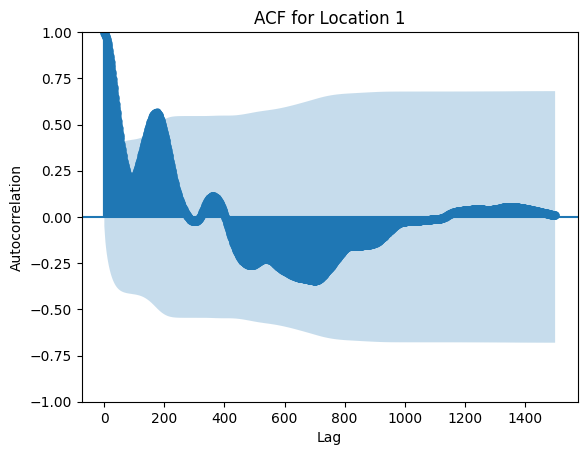

In [14]:
column_to_forecast = 'new_cases_smoothed'
# Построение графика автокорреляции
fig, ax = plt.subplots()
plot_acf(filtered_data[column_to_forecast], lags=1500 , ax=ax)
ax.set_title(f'ACF for Location 1')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')
plt.show()


График ACF имеет высокую степень изменчивости, что означает что нам следует использовать меньшие значения атрибута q.

Выведим график PACF

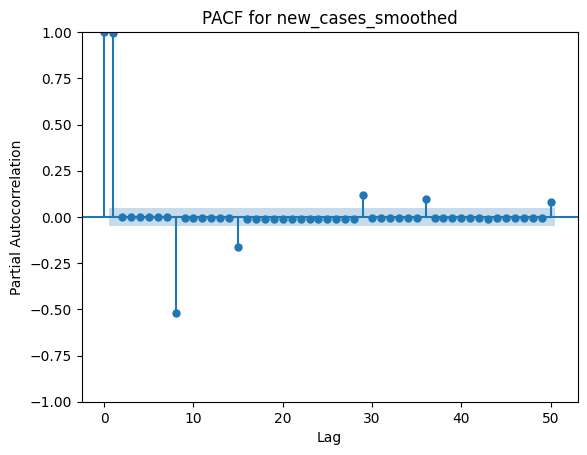

In [95]:
# Построение графика частной автокорреляции
fig, ax = plt.subplots()
plot_pacf(filtered_data[column_to_forecast], lags=50, ax=ax)
ax.set_title(f'PACF for {column_to_forecast}')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')
plt.show()

Так как большая часть параметров не выходит за пределы интервалов стандартного отклонения, то мы можем брать более низкие значения атрибута p.

### Экспоненциальное сглаживание

In [35]:
alpha = 0.2
# первое значение совпадает со значением временного ряда
exp_smoothing = [filtered_data['new_cases_smoothed'].iloc[0]]
 
# в цикле for последовательно применяем формулу ко всем элементам ряда
for i in range(1, len(filtered_data['new_cases_smoothed'])):
  exp_smoothing.append(alpha * filtered_data['new_cases_smoothed'].iloc[i] + (1 - alpha) * exp_smoothing[i - 1])
 
# выведем прогнозное значение для 366-го дня (1 января 1960 года)
exp_smoothing[-1]

9.362350897432966

In [36]:
len(filtered_data), len(exp_smoothing)

(1520, 1520)

In [37]:
exp_df=filtered_data.copy(deep=True)

In [38]:
# добавим кривую сглаживаия в качестве столбца в датафрейм
exp_df['Exp_smoothing'] = exp_smoothing
exp_df.tail(3)

,total_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,RT,LocationID,cluster,date,Exp_smoothing
3037,13140418.0,9.0,0.0,0.571,9209.105,0.0,0.006,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2024-03-01,12.378673
3038,13140418.0,9.0,0.0,0.571,9209.105,0.0,0.006,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2024-03-02,11.702939
3039,13140418.0,0.0,0.0,0.000,9209.105,0.0,0.000,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2,2024-03-03,9.362351


In [39]:
from datetime import datetime, timedelta
exp_df = exp_df.reset_index(drop=True)

# возьмём последний индекс (31 декабря 1959 года)
last_date = exp_df["date"].iloc[[-1]]

exp_df.info()

new_date = pd.DataFrame({'date': [last_date.item() + timedelta(days=1)]})
exp_df = pd.concat([exp_df, new_date], ignore_index=True)


print(last_date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 30 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   total_cases                                 1520 non-null   float64       
 1   new_cases_smoothed                          1520 non-null   float64       
 2   new_deaths                                  1520 non-null   float64       
 3   new_deaths_smoothed                         1520 non-null   float64       
 4   total_cases_per_million                     1520 non-null   float64       
 5   new_cases_per_million                       1520 non-null   float64       
 6   new_cases_smoothed_per_million              1520 non-null   float64       
 7   total_deaths_per_million                    1520 non-null   float64       
 8   new_deaths_per_million                      1520 non-null   float64       
 9   new_deat

In [40]:
len(exp_df)

1521

In [41]:
exp_df.tail()

,total_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,RT,LocationID,cluster,date,Exp_smoothing
1516,13140418.0,9.0,0.0,0.571,9209.105,0.0,0.006,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2024-02-29,13.223342
1517,13140418.0,9.0,0.0,0.571,9209.105,0.0,0.006,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2024-03-01,12.378673
1518,13140418.0,9.0,0.0,0.571,9209.105,0.0,0.006,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2024-03-02,11.702939
1519,13140418.0,0.0,0.0,0.000,9209.105,0.0,0.000,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2024-03-03,9.362351
1520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-04,NaN


In [42]:
exp_df['Exp_smoothing'] = exp_df['Exp_smoothing'].shift(1)

In [43]:
exp_df.head()

,total_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,RT,LocationID,cluster,date,Exp_smoothing
0,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2020-01-05,NaN
1,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2020-01-06,0.0
2,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2020-01-07,0.0
3,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2020-01-08,0.0
4,0.0,0.0,0.0,0.0,111435.417056,0.0,0.0,914.293131,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2020-01-09,0.0


In [44]:
exp_df.tail()

,total_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,human_development_index,RT,LocationID,cluster,date,Exp_smoothing
1516,13140418.0,9.0,0.0,0.571,9209.105,0.0,0.006,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2024-02-29,14.279177
1517,13140418.0,9.0,0.0,0.571,9209.105,0.0,0.006,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2024-03-01,13.223342
1518,13140418.0,9.0,0.0,0.571,9209.105,0.0,0.006,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2024-03-02,12.378673
1519,13140418.0,0.0,0.0,0.000,9209.105,0.0,0.000,181.596,0.0,0.0,...,10.793472,32.910575,50.791457,3.0973,0.722528,0.0,1.0,2.0,2024-03-03,11.702939
1520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-04,9.362351


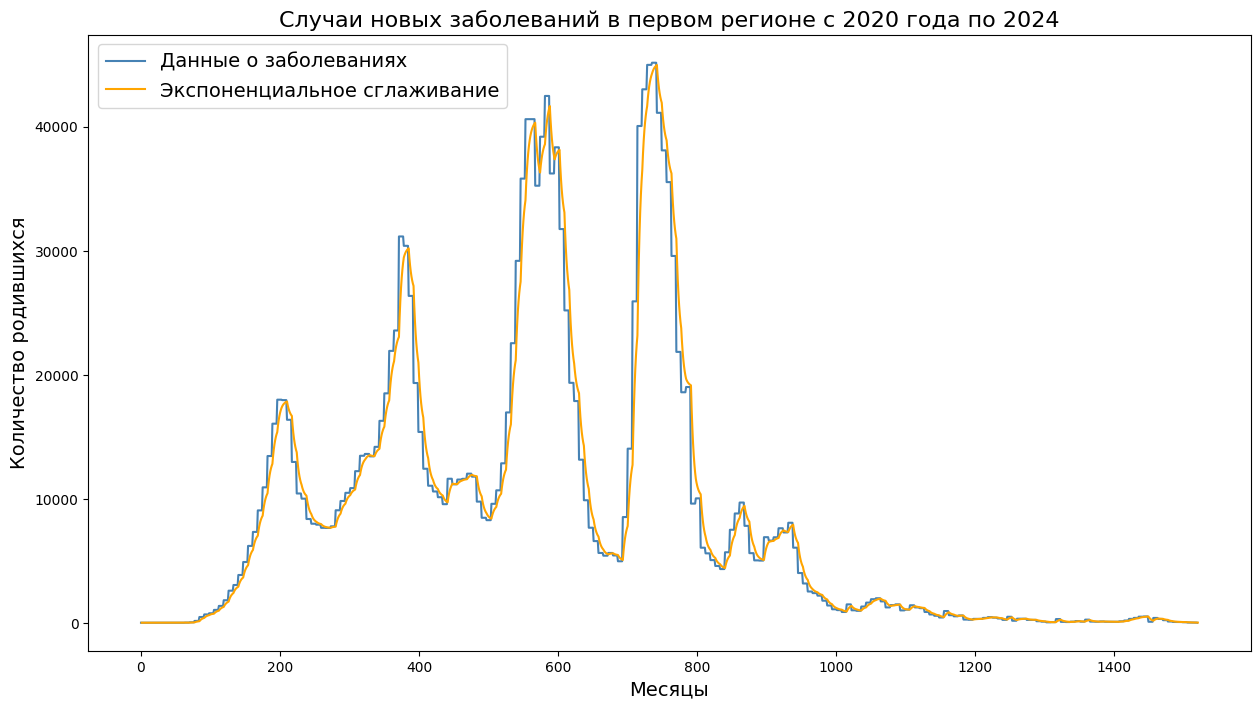

In [45]:
# зададим размер
plt.figure(figsize = (15,8))
 
# выведем данные о рождаемости и кривую экспоненциального сглаживания
plt.plot(exp_df['new_cases_smoothed'], label = 'Данные о заболеваниях', color = 'steelblue')
plt.plot(exp_df['Exp_smoothing'], label = 'Экспоненциальное сглаживание', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
# добавим подписи к осям и заголовки
plt.ylabel('Количество родившихся', fontsize = 14)
plt.xlabel('Месяцы', fontsize = 14)
plt.title('Случаи новых заболеваний в первом регионе с 2020 года по 2024', fontsize = 16)
 
plt.show()

### Модель ARMA

In [216]:
train = filtered_data[:int(len(filtered_data) * 0.5)]
test = filtered_data[int(len(filtered_data) * 0.5):]

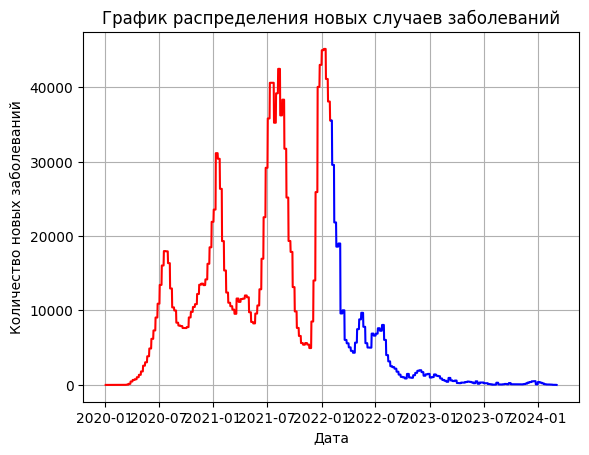

In [217]:
# Assuming 'train' and 'test' are DataFrames with columns 'date' and 'new_cases_smoothed'
plt.plot(train['date'], train['new_cases_smoothed'], color='red')
plt.plot(test['date'], test['new_cases_smoothed'], color='blue')

# Заголовок и подписи к осям
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')

# Добавим сетку
plt.grid()

plt.show()

Теперь обучим модель ARMA. Для параметров p и q берутся более низкие значения из стандартизированного дипазона от 0 до 5, так как мы выявили это по графикам ACF и PACF. Значение d равно 0, так как модель стационарна.

In [218]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 760 entries, 1520 to 2279
Data columns (total 29 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   total_cases                                 760 non-null    float64       
 1   new_cases_smoothed                          760 non-null    float64       
 2   new_deaths                                  760 non-null    float64       
 3   new_deaths_smoothed                         760 non-null    float64       
 4   total_cases_per_million                     760 non-null    float64       
 5   new_cases_per_million                       760 non-null    float64       
 6   new_cases_smoothed_per_million              760 non-null    float64       
 7   total_deaths_per_million                    760 non-null    float64       
 8   new_deaths_per_million                      760 non-null    float64       
 9   new_deaths_

In [247]:
from statsmodels.tsa.arima.model import ARIMA

# create ARMA model
model = ARIMA(train['new_cases_smoothed'], order=(4,0,4))

# fit model
result = model.fit()

D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [248]:

# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)
 
# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)


D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [249]:
predictions.tail()

1515    14424.287483
1516    14424.304622
1517    14424.321293
1518    14424.337489
1519    14424.353207
Name: predicted_mean, dtype: float64

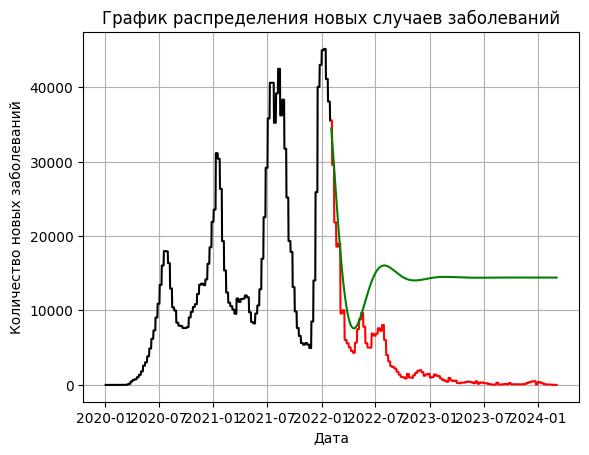

In [250]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train['date'], train['new_cases_smoothed'], color = "black")
plt.plot(test['date'], test['new_cases_smoothed'], color = "red")
plt.plot(test['date'], predictions, color = "green")
 
# заголовок и подписи к осям
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')


plt.axis('tight')
# добавим сетку
plt.grid()
 
plt.show()

Несмотря на неточное отображение показателей, модель вполне успешно прогнозировала падение заболеваемости.

In [183]:
# импортируем метрику
from sklearn.metrics import mean_squared_error
 
# рассчитаем MSE
print(mean_squared_error(test["new_cases_smoothed"], predictions))
 
# и RMSE
print(np.sqrt(mean_squared_error(test["new_cases_smoothed"], predictions)))

350701072.34593016
18727.014507014464


## 3.2 Визуализация работы регрессионной модели

In [254]:
# прогнозный период с конца имеющихся данных
start = len(filtered_data)

# и закончится через 2 месяца
end = start + 60

# теперь построим прогноз на два месяца вперед
forecast = result.predict(start, end)

# посмотрим на прогноз для двух месяцев
print(forecast)

1520    14424.368441
1521    14424.383187
1522    14424.397444
1523    14424.411207
1524    14424.424477
            ...     
1576    14424.538273
1577    14424.533134
1578    14424.527887
1579    14424.522539
1580    14424.517100
Name: predicted_mean, Length: 61, dtype: float64


D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


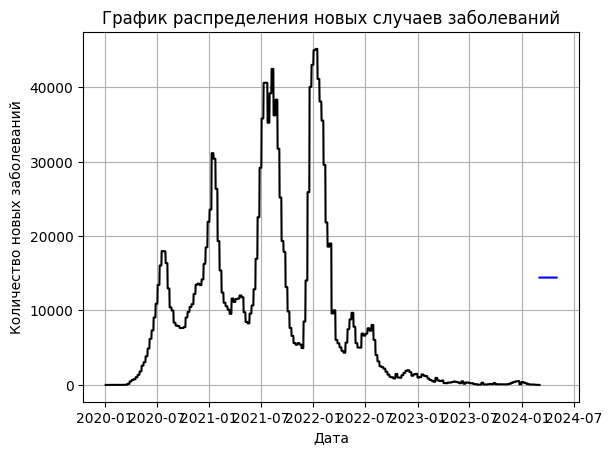

In [261]:
# Получить последнюю дату
last_date = filtered_data['date'].max()

# Добавить два месяца к последней дате
last_date_plus_two_months = last_date + pd.DateOffset(months=2)  - pd.Timedelta(days=1)



# Создать диапазон дат с шагом в один день
date_range = pd.date_range(last_date, last_date_plus_two_months, freq='D')


# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(filtered_data['date'], filtered_data['new_cases_smoothed'], color = 'black')
plt.plot(date_range, forecast, color = 'blue')
 
# заголовок и подписи к осям
plt.title('График распределения новых случаев заболеваний')
plt.ylabel('Количество новых заболеваний')
plt.xlabel('Дата')
 
# добавим сетку
plt.grid()
 
plt.show()